In [298]:
import pandas as pd
import json
from datetime import datetime
from collections import Counter

In [299]:
y_review = '/Users/madshelt/Downloads/dataset/review.json'
y_business = '/Users/madshelt/Downloads/dataset/business.json'

In [300]:
def yelp_data_generator(file_path):
    with open(file_path) as f:
        for line in f:
            # yield the the data line-by-line
            yield json.loads(line.rstrip())

In [301]:
# create generator object
reviews = yelp_data_generator(y_review)

In [302]:
business = yelp_data_generator(y_business)

In [303]:
# converting generator object to data frame
t1 = datetime.now()
df_reviews = pd.DataFrame.from_records(reviews, coerce_float=True, exclude=['review_id','user_id','date'])
print(datetime.now() - t1)

0:12:02.637345


In [304]:
t1 = datetime.now()
df_business = pd.DataFrame.from_records(business, coerce_float=True, exclude=['name','neighborhood','address','city',
                                                                             'latitude', 'longitude',
                                                                             'stars', 'review_count', 'is_open',
                                                                             'attributes', 'categories', 'hours'])
print(datetime.now() - t1)

0:00:45.932082


In [309]:
len(df_reviews)

4736897

In [310]:
len(df_business)

156639

In [311]:
df_reviews.head()

,business_id,cool,funny,stars,text,useful
0,uYHaNptLzDLoV_JZ_MuzUA,0,0,5,My girlfriend and I stayed here for 3 nights a...,0
1,uYHaNptLzDLoV_JZ_MuzUA,0,0,3,If you need an inexpensive place to stay for a...,0
2,uYHaNptLzDLoV_JZ_MuzUA,0,0,3,Mittlerweile gibt es in Edinburgh zwei Ableger...,0
3,uYHaNptLzDLoV_JZ_MuzUA,0,0,4,Location is everything and this hotel has it! ...,0
4,uYHaNptLzDLoV_JZ_MuzUA,0,0,5,gute lage im stadtzentrum. shoppingmeile und s...,0


In [312]:
df_business.head()

,business_id,postal_code,state
0,YDf95gJZaq05wvo7hTQbbQ,44143,OH
1,mLwM-h2YhXl2NCgdS84_Bw,28215,NC
2,v2WhjAB3PIBA8J8VxG3wEg,M4K 1N7,ON
3,CVtCbSB1zUcUWg-9TNGTuQ,85258,AZ
4,duHFBe87uNSXImQmvBh87Q,85016,AZ


**Scraping US states from Wikipedia**

In [313]:
from bs4 import BeautifulSoup
import requests 
text = requests.get('https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States').text 
text = BeautifulSoup(text, 'html.parser')

In [314]:
state_list = []
for i in text.find('table', attrs = {'class': 'wikitable'}).find_all('tr')[2:]:
    cells = i.find_all(["td"])
    state_list.append(cells[0].get_text()[0:2])

**Merge review and business**

In [315]:
df = pd.merge(left = df_reviews, right = df_business, how = 'inner', on = 'business_id')

In [316]:
df.head()

,business_id,cool,funny,stars,text,useful,postal_code,state
0,uYHaNptLzDLoV_JZ_MuzUA,0,0,5,My girlfriend and I stayed here for 3 nights a...,0,EH1,EDH
1,uYHaNptLzDLoV_JZ_MuzUA,0,0,3,If you need an inexpensive place to stay for a...,0,EH1,EDH
2,uYHaNptLzDLoV_JZ_MuzUA,0,0,3,Mittlerweile gibt es in Edinburgh zwei Ableger...,0,EH1,EDH
3,uYHaNptLzDLoV_JZ_MuzUA,0,0,4,Location is everything and this hotel has it! ...,0,EH1,EDH
4,uYHaNptLzDLoV_JZ_MuzUA,0,0,5,gute lage im stadtzentrum. shoppingmeile und s...,0,EH1,EDH


In [317]:
# filter out non-US states
sub_df = df.loc[(df['state'].isin(state_list))]

In [318]:
len(sub_df)

3952097

In [320]:
sub_df = sub_df.drop(['business_id', 'postal_code', 'state'], axis=1)

In [321]:
sub_df.head()

,cool,funny,stars,text,useful
16,0,0,1,"This place is horrible, we were so excited to ...",0
17,0,0,4,"For being fairly ""fast"" food.. Pei Wei (pronou...",1
18,1,1,5,"I decided to try it out, I'm celiac and theref...",2
19,1,1,3,I'm not saying Pei Wei is the best asian food ...,1
20,0,0,3,Sometimes the food is spot on and delicious an...,0


**Downsampling to get a balanced dataset**

In [553]:
# multilabel downsampling
from collections import Counter

def balance_classes(xs, ys):
    """Undersample xs, ys to balance classes."""
    freqs = Counter(ys)

    # the least common class is the maximum number we want for all classes
    max_allowable = 100000 #freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i, y in enumerate(ys):
        if num_added[y] < max_allowable:
            new_ys.append(y)
            new_xs.append(xs[i])
            num_added[y] += 1
    return new_xs, new_ys

In [555]:
texts = [review for review in sub_df['text']]
binstars = [star for star in sub_df['stars']]

In [556]:
print(Counter(binstars))
balanced_x, balanced_y = balance_classes(texts, binstars)
print(Counter(balanced_y))

Counter({5: 1746160, 4: 884962, 1: 558811, 3: 435600, 2: 326564})
Counter({1: 100000, 2: 100000, 3: 100000, 4: 100000, 5: 100000})


In [368]:
# binary downsampling
texts = [review for review in sub_df['text']]

# Convert 5 classes of rating into binary - 0 for negative and 1 for positive
binstars = [0 if review <= 3 else 1 for review in sub_df['stars']]

balanced_texts = []
balanced_labels = []
limit = 1000
neg_pos_counts = [0, 0]

for i in range(len(texts)):
    polarity = binstars[i]
    if neg_pos_counts[polarity] < limit:
        balanced_texts.append(texts[i])
        balanced_labels.append(binstars[i])
        neg_pos_counts[polarity] += 1

In [95]:
# check to see if we have 100k for each label
Counter(balanced_labels)

Counter({0: 100000, 1: 100000})

In [112]:
# removing empty lines
balanced_ = []
for word in balanced_texts:
    balanced_.append(re.sub('\n',"", word))

In [115]:
# writing out txt file with reviews
with open('./Desktop/Dataset/balanced_text.txt', 'w') as file:
    for review in balanced_:
        file.write("%s\n" % review)

In [116]:
# writing out txt file with labels
with open('./Desktop/Dataset/balanced_label.txt', 'w') as file:
    for label in balanced_labels:
        file.write("%i\n" % label)

**Data Preparation ** <br>
*The manual way*

First step is to clean the text. This is a never-ending job, so the objective is to clean the text as simple as possible. Primarily focused on "tokenization", meaning splitting text into tokens, where each word is a token.

*Chapter 5*
- Clean text manually
    + Manual Tokenization
        + Split by Whitespace (select words)
        + Select Words (with re)
        + Remove punctuation
        + Normalizing Case (lowercase)
- Clean text with NLTK
    + Split into sentences
    + Split into words
    + Filter out punctuation
    + Filter out stop words
    + Stem words 

Next step is to encode words as integers or floating point values (this is called "vectorization"). Algorithms take fixed-length vectors of numbers as input.

*Chapter 6 - scikit-learn* 

Scikit-learn can perform both tokenization and feature extraction of the text. Bag-of-Words Model is used as a base.
- CountVectorizer (both tokenization and vocabulary)
- TfidVectorizer (word frequencies)
    + Note: input can be a learned CountVectorizer 
- HashingVectorizer

The books mentions that there are several other configurations to influence the tokenizing of text that are worth exploring.

*Chapter 7 - Keras*

The Keras deep learning library provides some basic tools to prepare the text. Some of these methods overlap (is a mix) with the methods specified in chapter 5 and 6.
- Text_to_word_sequence (split words) - does 3 things:
    + 1) Splits words by space, 2) filter out punctuation, 3) converts text to lowercase
- one_hot encoding - does 3 things:
    + 1) Splits words by space, 2) filter out punctuation, 3) converts text to lowercase
    + text_to_word_sequence can be used as a pre-step to represent only the unique words in the document
- hashing_trick (hash encoding)
- Tokenizer (API)
    + class to prepare text with not just one-off methods like the 3 above.
    + Tokenizer can be fit on either raw text documents or integer encoded text documents. 


*Word Embedding*

"it may no-longer make sense to stem words or remove punctuation for contractions... He (Mikolov) suggest only very minimal text cleaning is required when learning a word embedding model."


**Splitting in train and test set**

In [46]:
# import balanced_text
with open('./Desktop/Dataset/balanced_text.txt', 'r') as file:
    balanced_text = file.readlines()

In [47]:
len(balanced_text)

200234

In [48]:
# import balanced_labels
import numpy as np
balanced_labels = []
with open('./Desktop/Dataset/balanced_label.txt', 'r') as file:
    for label in file:
        balanced_labels.append(label.strip())

In [49]:
len(balanced_labels)

200000

In [5]:
import pandas as pd
df = pd.DataFrame(data = list(zip(balanced_text,
                                     balanced_labels)),
            columns = ['text', 'sentiment'], dtype = 'int' )

In [53]:
df.shape

(200000, 2)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['sentiment'], 
                                                    test_size=0.2, 
                                                    random_state=42)

**Exporting datasets**

In [2]:
with open('./Desktop/Dataset/X_train.txt', 'w') as file:
    for dataset in X_train:
        file.write("%s" % dataset)

In [10]:
with open('./Desktop/Dataset/X_test.txt', 'w') as file:
    for dataset in X_test:
        file.write("%s" % dataset)

In [11]:
y_train.to_csv('./Desktop/Dataset/y_train.txt', index=False)

In [12]:
y_test.to_csv('./Desktop/Dataset/y_test.txt', index = False)

**Importing y_train and y_test**

In [25]:
import numpy as np
text_file = open('./Desktop/Dataset/y_train.txt', 'r')
y_train = text_file.read().split('\n')
y_train = [list(map(int, x)) for x in y_train]
y_train = y_train[:-1]
y_train = np.array(y_train).ravel()

In [26]:
text_file = open('./Desktop/Dataset/y_test.txt', 'r')
y_test = text_file.read().split('\n')
y_test = [list(map(int, x)) for x in y_test]
y_test = y_test[:-1]
y_test = np.array(y_test).ravel()

**Develop Word2vec Embedding**

We need to build an iterator that loads the text, instead of loading all text into memory since this can use up a lot of RAM for a large corpora. 

Gensim's word2vec expects a sequence of sentences as its input. Therefore, we can build an iterator and provide gensim with one sentence at a time, process it, forget it, and load another sentence.

In [3]:
# iterator for the non-empty reviews
import re

class MyCorpus(object):  
    def __init__(self, filename):
        self.filename = filename
        
    def __iter__(self):
        for line in open(self.filename):
            review = re.sub("[^a-zA-Z]"," ", line)
            review = review.lower().split()
            if review:
                yield review

In [1]:
# iterator to store the index of non-empty reviews
class MyCorpus_index(object):  
    def __init__(self, filename):
        self.filename = filename
        
    def __iter__(self):
        count = -1
        for line in open(self.filename):
            review = re.sub("[^a-zA-Z]"," ", line)
            review = review.lower().split()
            count += 1
            if review:
                yield count

In [8]:
balanced_t = MyCorpus('./Desktop/Dataset/balanced_text.txt')

In [9]:
tokened = []
for word in balanced_t:
    tokened.append(word)

In [4]:
# save iterator object for train reviews
reviews_train = MyCorpus('./Desktop/Dataset/X_train.txt')

In [19]:
# save iterator object for test reviews
reviews_test = MyCorpus('./Desktop/Dataset/X_test.txt')

In [21]:
# save iterator object for train index number
index_train = MyCorpus_index('./Desktop/Dataset/X_train.txt')

In [22]:
# save iterator object for train index number
index_test = MyCorpus_index('./Desktop/Dataset/X_test.txt')

In [23]:
# save index numbers for non-empty reviews in training set
indices_train = []
for index_num in index_train:
    indices_train.append(index_num)

In [24]:
# save index numbers for non-empty reviews in testing set
indices_test = []
for index_num in index_test:
    indices_test.append(index_num)

In [27]:
# filter out labels for corresponding empty reviews
y_train = y_train[indices_train]
print("No. of empty reviews filtered out: ", 160000 - len(y_train))

No. of empty reviews filtered out:  86


In [28]:
# filter out labels for corresponding empty reviews
y_test = y_test[indices_test]
print("No. of empty reviews filtered out: ", 40000 - len(y_test))

No. of empty reviews filtered out:  22


In [71]:
%%time
import os
from gensim.models import Word2Vec
import multiprocessing
cores = multiprocessing.cpu_count()

if not os.path.exists('./Desktop/Dataset/word2vec'):
    print("start training word2vec model...")
    #sentences = MySentences() # a memory-friendly iterator
    word2vec_model = Word2Vec(reviews_train, min_count=5, size=300, workers=cores)
    if not os.path.exists('./Desktop/Dataset/word2vec'):
        os.makedirs('./Desktop/Dataset/word2vec')
        word2vec_model.wv.save_word2vec_format('./Desktop/Dataset/word2vec300.txt', binary=False)
    else:
        word2vec_model.wv.save_word2vec_format('./Desktop/Dataset/word2vec300.txt', binary=False)
else:
    word2vec_model = Word2Vec.load('./Desktop/Dataset/word2vec300.txt')

start training word2vec model...
CPU times: user 9min 3s, sys: 6.38 s, total: 9min 10s
Wall time: 3min 52s


In [45]:
print(word2vec_model)

Word2Vec(vocab=31287, size=200, alpha=0.025)


In [3]:
# Importing trained word2vec with 300 dim
from gensim.models import Word2Vec
model = Word2Vec.load('./Desktop/Dataset/word2vec/word2vec.model')

In [4]:
# dimension of word2vec model (vocabulary)
model.wv.syn0.shape

(31287, 300)

In [33]:
# printing trained word2vec model
print(model)

Word2Vec(vocab=31287, size=100, alpha=0.025)


In [16]:
words = list(model.wv.vocab)
print(words[0:25])

['threads', 'oils', 'starsthis', 'diffuse', 'mehr', 'westin', 'slathering', 'blends', 'sushimon', 'bile', 'garners', 'griping', 'chuy', 'adverse', 'hued', 'built', 'sind', 'poboy', 'arrival', 'dangling', 'nauseous', 'persona', 'humiliating', 'thali', 'condemned']


In [1131]:
# Word vectors: 100 dimensions for the word 'good'
print(model['good']) 

[ 1.01985347 -0.92030841 -0.36698216  0.29141989 -4.11649704  0.881863
  1.3686372   0.80261707  0.76257765 -0.35457465  1.23338819 -0.12996946
  0.75558692  0.81737649 -1.13246059  1.12607467  2.89836645  0.8002097
 -2.4531641  -1.37292945 -1.23263156  2.28367233 -0.19968054 -2.61984444
 -0.90037179 -2.15741515  1.11329913  0.52432126  1.75764751  1.21806061
  1.2726866   1.04156113  0.68980438 -0.47584215  1.18588352 -0.13512409
  0.89811528 -1.19637299 -3.57312942  0.60238284 -1.10418105 -0.50095367
 -4.20460558  1.85209751 -2.88727021  3.45114183 -1.1068213  -1.02261639
  2.87409043  2.26110959  2.2606895  -0.33208498  1.10801852 -0.77657634
 -0.17789106 -0.28216431  0.82387638 -2.9798398  -1.15588248 -0.67613989
  0.49363005 -2.70754743 -0.09256826  0.8114953   2.23548889  5.10977221
 -0.03705682  0.04739144  0.42341614  2.32812667  1.6929096   0.4161199
  0.73858583  1.02582514 -1.46915281  0.95640284 -1.34836721  2.14373422
  0.9122265  -0.64642918  1.20237935 -0.04327845 -0.267

In [27]:
# look up top10 most similar words
model.wv.most_similar('sushi')

[('sashimi', 0.6762856245040894),
 ('nigiri', 0.6616212129592896),
 ('seafood', 0.6350231766700745),
 ('poke', 0.567468523979187),
 ('ayce', 0.5664577484130859),
 ('ramen', 0.5485618114471436),
 ('maki', 0.5360989570617676),
 ('uni', 0.5323463678359985),
 ('pho', 0.5309431552886963),
 ('food', 0.5254984498023987)]

In [23]:
# calculate (spaghetti - italian) + chinese
model.most_similar(positive=['chinese', 'spaghetti'], negative=['italian'], topn=1)

[('wah', 0.5090364217758179)]

In [1135]:
# Return a Keras 'Embedding' layer with weights set as the Word2Vec model's learned word embeddings
embedding_layer = model.wv.get_keras_embedding()

In [1134]:
# output layer of the trained neural network (in this case we have 34334 words * 100 vectors)
model.wv.syn0

array([[-1.58051884,  0.361065  , -2.43268204, ..., -1.49426472,
        -0.59179926,  0.90500379],
       [-0.57821208,  0.72524977, -1.13111877, ...,  0.00877488,
         0.16908607,  0.86917043],
       [ 3.07706475, -2.0311029 ,  0.99512571, ...,  2.74762988,
        -2.06964278,  2.01257849],
       ..., 
       [-0.02107974,  0.07751742,  0.07365621, ...,  0.04360363,
        -0.0262667 , -0.00674342],
       [-0.00795934,  0.06846277, -0.03547641, ...,  0.01492627,
        -0.04258793,  0.05085544],
       [-0.02047236,  0.11883926,  0.03599071, ...,  0.06603737,
        -0.04432582,  0.01785531]], dtype=float32)

In [28]:
# probability distribution of the center word given the context words as input
model.predict_output_word(['this', 'place'])

[('gem', 0.015245982),
 ('love', 0.014233463),
 ('avoid', 0.012601318),
 ('sucks', 0.010963863),
 ('skip', 0.010406211),
 ('rocks', 0.0078356536),
 ('dump', 0.0074927113),
 ('deserves', 0.0050018546),
 ('recommend', 0.0038076825),
 ('patronize', 0.0037873483)]

***Methods to use after training word2vec***

There are some tricky methods to use to extract information about the training word embedding (word vector).

Get the vocabulary of the word embedding:

1. Extract the vocabulary
```python
model.wv.vocab
``` 

2. Extract vectors of a specific word (returns all dimensions)
```python
model['good']
model.wv.word_vec('spaghetti')
```

3. Return a list of top-10 similar words (probability distribution)
```python
model.wv.most_similar('price')
```

4. Extract the output layer (word vectors for each word)
```python
model.wv.syn0
```

5. Extract a Keras embedding layer (weight set as trained worc2vec model)
```python
model.wv.get_keras_embedding
```

6. Math operations to calculate similarity
```python
model.most_similar(positive=['chinese', 'spaghetti'], negative=['italian'], topn=1)
```

**Visualize Word2vec**

In [15]:
X = model[model.wv.vocab]

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
result = pca.fit_transform(X)

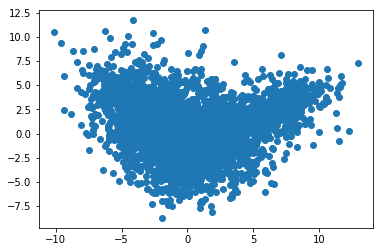

In [21]:
import matplotlib.pyplot as plt
plt.scatter(result[:, 0], result[:, 1])
plt.show()

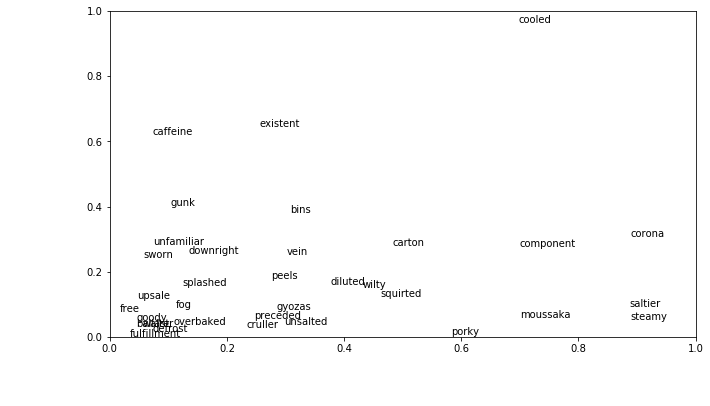

In [19]:
words = list(model.wv.vocab)[:500]
fig = plt.gcf()
fig.set_size_inches(10.5, 6)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    
plt.show()

**t-SNE** 

In [7]:
# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = list(model.wv.syn0)[:100]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
import pandas as pd
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(model.wv.vocab.keys())[:100]

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 9.215973
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.566873
[t-SNE] Error after 350 iterations: 1.566873


In [18]:
# 2-D plot with name-tags
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in list(model.wv.vocab.keys())[:100]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(n_components=2, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

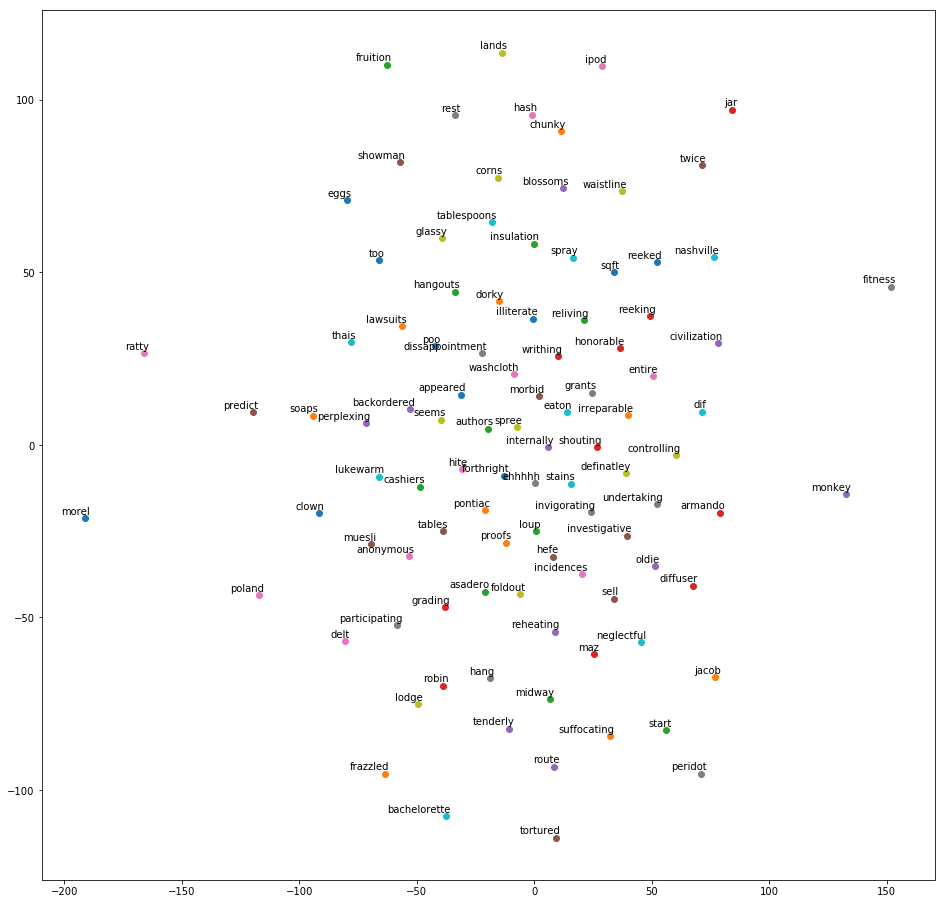

In [19]:
tsne_plot(model)

**From word vector to sentence vector**

Since we now have a trained word2vec embedding model that represents feature representation of each word in our vocabulary, we must average the word vectors so that they represent each review. This means that we must take the individual word vectors and transform them into a feature set that is the same length for every review.

There exists three ways to do it: 

1. **Doc2Vec** - train your dataset using Doc2vec and then use the sentence vectors.
2. **Average of Word2vec vectors** - takes the average of all the word vectors in a sentence. Then the average vector will represent your sentence vector.
3. **Average of Word2vec vectors with TF-IDF** - takes the word vectors and multiply it with their TF-IDF sources. Just take the average and it will represent your sentence vector (highly recommendable). 

[Link to Kaggle tutorial](https://www.kaggle.com/c/word2vec-nlp-tutorial#description)

***Method 2: Average of word2vec***

In [35]:
import numpy as np 
num_features = 300

def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given paragraph

    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")

    nwords = 0.

    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
    
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 

    # Initialize a counter
    counter = 0.

    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews), num_features),dtype="float32")

    # Loop through the reviews
    for review in reviews:

       # Print a status message every 1000th review
       if int(counter)%1000. == 0.:
            print("Review %d of %d" % (counter, len(reviews)))

       # Call the function (defined above) that makes average feature vectors
       reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, num_features)

       # Increment the counter
       counter = counter + 1.
    return reviewFeatureVecs

In [37]:
# Calculate average feature vectors for training and testing sets using function above
print("Creating average feature vecs for train reviews")
words_train = []
for vector in reviews_train:
    words_train.append(vector)
    
trainDataVecs = getAvgFeatureVecs(words_train, model, num_features)

print("Creating average feature vecs for test reviews")
words_test = []
for vector in reviews_test:
    words_test.append(vector)

testDataVecs = getAvgFeatureVecs(words_test, model, num_features)

Creating average feature vecs for train reviews
Creating average feature vecs for test reviews
Review 0 of 39978
Review 1000 of 39978
Review 2000 of 39978
Review 3000 of 39978
Review 4000 of 39978
Review 5000 of 39978
Review 6000 of 39978
Review 7000 of 39978
Review 8000 of 39978
Review 9000 of 39978
Review 10000 of 39978
Review 11000 of 39978
Review 12000 of 39978
Review 13000 of 39978
Review 14000 of 39978
Review 15000 of 39978
Review 16000 of 39978
Review 17000 of 39978
Review 18000 of 39978
Review 19000 of 39978
Review 20000 of 39978
Review 21000 of 39978
Review 22000 of 39978
Review 23000 of 39978
Review 24000 of 39978
Review 25000 of 39978
Review 26000 of 39978
Review 27000 of 39978
Review 28000 of 39978
Review 29000 of 39978
Review 30000 of 39978
Review 31000 of 39978
Review 32000 of 39978
Review 33000 of 39978
Review 34000 of 39978
Review 35000 of 39978
Review 36000 of 39978
Review 37000 of 39978
Review 38000 of 39978
Review 39000 of 39978


In [74]:
print(trainDataVecs.shape)
print(testDataVecs.shape) 

(159914, 300)
(39978, 300)


**Conclusion** <br>
Now we have sentence vectors for both our train and test set, where we have used our trained word2vec model to average each word vector into a sentence vector for each review. In other words, we have sent our reviews in the train and test set through the word2vec model and then the output becomes an averaged sentence vector for each review. The job of the word2vec model is now done, and the next step is to use the two new datasets (trainDataVecs and testDataVecs) to build a classifier model to predict whether or not a review is positive or negative. In this case, let's try to build a logistic regression to predict the sentiment.

**Predicting sentiment using a Logistic Regression classifier**

In [38]:
# extracting missing values from train data
abcd = pd.DataFrame(trainDataVecs, columns = range(300)).apply(lambda x: np.isnan(x))
index_train = abcd.loc[abcd[1] == True, ].index.values

In [39]:
# filter out bad reviews from train data
trainDataVecs_ = np.delete(trainDataVecs, index_train, axis = 0)
y_train_ = np.delete(y_train, index_train, axis = 0)

In [40]:
# extracting missing values from test data
abcde = pd.DataFrame(testDataVecs, columns = range(300)).apply(lambda x: np.isnan(x))

In [41]:
# filter out bad reviews from test data
testDataVecs_ = np.delete(testDataVecs, abcde.loc[abcde[1] == True, ].index.values, axis = 0)
y_test_ = np.delete(y_test, abcde.loc[abcde[1] == True, ].index.values, axis = 0)

In [42]:
print(trainDataVecs_.shape)
print(testDataVecs_.shape) 

(159912, 300)
(39978, 300)


In [18]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

In [104]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

logic = LogisticRegression(C=1e4) # C = 1e4
logic.fit(trainDataVecs_, y_train_)
y_pred = logic.predict(testDataVecs_)
confusion_matrix(y_test_, y_pred)

array([[13258,  6882],
       [ 7205, 12633]])

**Roc Curve**

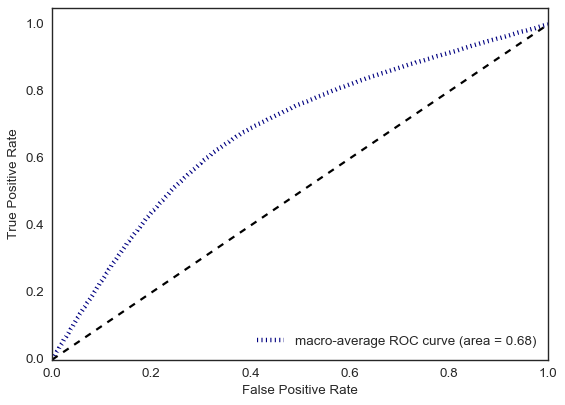

In [182]:
# roc curve for word2vec
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc_curve(y_test_, preds, title="", cmap="OrRd", curves='macro', text_fontsize='large')
plt.style.use('seaborn-colorblind')
plt.show()

**Develop Doc2vec Embedding**

The input to Doc2Vec is an iterator of "LabeledSentence objects". Each such object represents a single sentence, and consists of two simple lists: a list of words and a list of labels, such as the following:
```python
sentence = LabeledSentence(words=[u'some', u'words', u'here'], labels=[u'SENT_1'])
``` 
The algorithm then runs through the sentences iterator twice: once to build the vocab, and once to train the model on the input data, i.e. learning a vector representation for each word and for each label in the dataset. It's preferable to have a single label per sentence which is the unique identifier for the sentence. 

This is an example of how to build the iterator:

```python
class LabeledLineSentence(object):
    def __init__(self, filename):
        self.filename = filename
    def __iter__(self):
        for uid, line in enumerate(open(filename)):
            yield LabeledSentence(words=line.split(), labels=['SENT_%s' % uid])
```         

When we have trained the Doc2vec embedding, we can inspect the output layer. Remember that this contains both the word vectors and the sentence vectors. For sentiment analysis, in this case particular, we are only interested in using the sentence vectors, so we should only extract that.


**Import data**

In [91]:
with open('./Desktop/balanced/balanced_text.txt', 'r') as file:
    balanced_text = file.readlines()

In [82]:
import numpy as np
balanced_labels = []
with open('./Desktop/balanced/balanced_label.txt', 'r') as file:
    for label in file:
        balanced_labels.append(label.strip())

**Splitting in positive and negative reviews for both training and testing set**

In [50]:
all_ = list(zip(balanced_labels, balanced_text))

import pandas as pd
import numpy as np
df = pd.DataFrame(np.array(all_).reshape(-1, 2),
                  columns = ['sentiment', 'text'])
print(df.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], 
                                                    test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

train_neg = train[train['sentiment'] == '0']
train_pos = train[train['sentiment'] == '1']

test_neg = test[test['sentiment'] == '0']
test_pos = test[test['sentiment'] == '1']

print(train_neg.shape)
print(train_pos.shape)
print(test_neg.shape)
print(test_pos.shape)

(200000, 2)
(79854, 2)
(80146, 2)
(20146, 2)
(19854, 2)


**Exporting datasets**

In [1171]:
with open('./Desktop/Dataset/Doc2vec/X_train_neg.txt', 'w') as file:
    for dataset in train_neg.text:
        file.write("%s" % dataset)

In [1172]:
with open('./Desktop/Dataset/Doc2vec/X_train_pos.txt', 'w') as file:
    for dataset in train_pos.text:
        file.write("%s" % dataset)

In [1173]:
with open('./Desktop/Dataset/Doc2vec/X_test_neg.txt', 'w') as file:
    for dataset in test_neg.text:
        file.write("%s" % dataset)

In [1174]:
with open('./Desktop/Dataset/Doc2vec/X_test_pos.txt', 'w') as file:
    for dataset in test_pos.text:
        file.write("%s" % dataset)

In [51]:
# iterator to build iterator to get a labeled sentence for every review
# Each review will get a unique label name
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from random import shuffle

class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).lower().split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).lower().split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffle(self.sentences)
        return self.sentences

In [52]:
sources = {'./Desktop/Dataset/Doc2vec/X_train_pos.txt':'X_train_pos', 
           './Desktop/Dataset/Doc2vec/X_train_neg.txt': 'X_train_neg',
           './Desktop/Dataset/Doc2vec/X_test_pos.txt':'X_test_pos',
          './Desktop/Dataset/Doc2vec/X_test_neg.txt':'X_test_neg'}

sentences = LabeledLineSentence(sources)

In [54]:
from datetime import datetime
from gensim.models import Doc2Vec

model_doc = Doc2Vec(min_count=5, window=10, size=200, sample=1e-4, negative=5, workers=4)

In [55]:
# building the vocabulary table based on a sentence that is transformed to an array
t1 = datetime.now()
model_doc.build_vocab(sentences.to_array())
print(datetime.now() - t1)

0:02:24.061056


In [56]:
# Update the model's neural weights from a sequence of sentences
t1 = datetime.now()
model_doc.train(sentences.sentences_perm(), total_examples = model_doc.corpus_count , epochs=20) # try epocs = 20
print(datetime.now() - t1)

0:16:23.636350


In [57]:
# probability distribution for similar words to 'good'
model_doc.most_similar('good')

[('great', 0.7898271083831787),
 ('decent', 0.7330671548843384),
 ('good.', 0.7314693927764893),
 ('good,', 0.6684339046478271),
 ('nice', 0.6395761966705322),
 ('bad', 0.6315627098083496),
 ('tasty', 0.6027035713195801),
 ('great.', 0.5922949910163879),
 ('great,', 0.5726982355117798),
 ('decent.', 0.5526214838027954)]

In [59]:
# saving doc2vec model
model_doc.save('./Desktop/Dataset/Doc2vec/yelp.d2v')

In [60]:
from gensim.models import Doc2Vec
# importing doc2vec model
model_doc_import = Doc2Vec.load('./Desktop/Dataset/Doc2vec/yelp.d2v')

In [61]:
model_doc_import.most_similar('fish')

[('fish.', 0.6895637512207031),
 ('fish,', 0.6202603578567505),
 ('nigiri', 0.5205651521682739),
 ('cod', 0.5204713344573975),
 ('unagi', 0.5132443904876709),
 ('seafood', 0.5030338764190674),
 ('salmon', 0.4975736737251282),
 ('sashimi', 0.4761657416820526),
 ('hamachi', 0.4717949330806732),
 ('flounder', 0.4706231653690338)]

In [62]:
# review vectors (here first review in X_train_neg)
model_doc_import.docvecs['X_train_neg_0']

array([ 0.05723703,  0.02506099,  0.00478442,  0.09239999,  0.2181482 ,
        0.30090258, -0.31572685,  0.35202399, -0.081339  , -0.06962027,
        0.18615982, -0.14495251, -0.45737255, -0.04203847, -0.00458761,
        0.03712136, -0.1994724 ,  0.05373072, -0.51726788, -0.30555603,
       -0.01738849,  0.35424221,  0.52311349,  0.00124774,  0.17236309,
       -0.13164246,  0.14018424, -0.02293913, -0.09835874,  0.10018221,
       -0.10286072,  0.05008406,  0.15384345, -0.12754834,  0.0630961 ,
        0.1523937 ,  0.47677946,  0.53522021,  0.04636433,  0.32899195,
       -0.09651081, -0.16787833,  0.03067501,  0.29267827,  0.00638465,
        0.21417671,  0.10037163, -0.08897642, -0.08850767, -0.01632792,
       -0.05703628, -0.01756952,  0.07125048, -0.1049198 , -0.07398388,
        0.01479555, -0.09231389, -0.04096193, -0.21868256, -0.12658153,
        0.08357162,  0.15046114,  0.14419559, -0.03851757,  0.09787857,
        0.19067596,  0.15153609,  0.34792754,  0.17442791,  0.19

In [63]:
# most similar reviews (here review 0)
model_doc_import.docvecs.most_similar(0)

[('X_train_pos_19349', 0.5219781398773193),
 ('X_train_pos_59182', 0.5057666301727295),
 ('X_train_neg_48116', 0.5024051666259766),
 ('X_train_neg_65767', 0.5023511052131653),
 ('X_test_pos_1181', 0.4995582103729248),
 ('X_test_neg_9459', 0.4943637251853943),
 ('X_test_pos_18527', 0.4920172393321991),
 ('X_test_pos_8738', 0.49063244462013245),
 ('X_train_neg_2671', 0.48724856972694397),
 ('X_test_pos_9099', 0.48430681228637695)]

In [64]:
# Creating training set
import numpy as np

train_arrays = np.zeros((150000, 200))
train_labels = np.zeros(150000)
for i in range(75000):
    prefix_train_pos = 'X_train_pos_' + str(i)
    prefix_train_neg = 'X_train_neg_' + str(i)
    train_arrays[i] = model_doc_import.docvecs[prefix_train_pos]
    train_arrays[12500 + i] = model_doc_import.docvecs[prefix_train_neg]
    train_labels[i] = 1
    train_labels[12500 + i] = 0

In [65]:
# Creating test set
test_arrays = np.zeros((35000, 200))
test_labels = np.zeros(35000)
for i in range(17500):
    prefix_test_pos = 'X_test_pos_' + str(i)
    prefix_test_neg = 'X_test_neg_' + str(i)
    test_arrays[i] = model_doc_import.docvecs[prefix_test_pos]
    test_arrays[12500 + i] = model_doc_import.docvecs[prefix_test_neg]
    test_labels[i] = 1
    test_labels[12500 + i] = 0

In [66]:
# logistic regression classifier
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(train_arrays, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
classifier.score(test_arrays, test_labels)

0.64328571428571424

In [75]:
# confusion matrix
import seaborn as sns
import pandas_ml as pdml
from pandas_ml import ConfusionMatrix 
from matplotlib import pyplot as plt

# test labels
preds_ = classifier.predict(test_arrays)
confusion_matrix(test_labels, preds_)

array([[ 6132, 11368],
       [ 1117, 16383]])

** Bag-of-Words Model **

In [1]:
with open('./Desktop/Dataset/X_train.txt', 'r') as file:
    X_train = file.readlines()

In [4]:
# tokenization function
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def review_to_words(raw_review):
   
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 

    words = letters_only.lower().split()                             

    stops = set(stopwords.words("english"))                  

    meaningful_words = [w for w in words if not w in stops] 
    
    stemmer = PorterStemmer()
    
    stem_ = [stemmer.stem(word) for word in meaningful_words]

    return(" ".join(stem_))   

In [5]:
# append every review to nested list
X_train_clean = []
for sentence in X_train:
    X_train_clean.append(review_to_words(sentence))

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 5000) 

In [7]:
train_data_features = vectorizer.fit_transform(X_train_clean)
train_data_features = train_data_features.toarray()

In [85]:
# Vocabulary 
vocab_ = vectorizer.get_feature_names()
print(vocab_[:25])

['abandon', 'abil', 'abl', 'absolut', 'absurd', 'abund', 'abus', 'ac', 'accent', 'accept', 'access', 'accessori', 'accid', 'accident', 'accommod', 'accomod', 'accompani', 'accomplish', 'accord', 'accordingli', 'account', 'accur', 'accus', 'accustom', 'ach']


In [86]:
# importing y_train
text_file = open('./Desktop/Dataset/y_train.txt', 'r')
y_train = text_file.read().split('\n')
y_train = [list(map(int, x)) for x in y_train]
y_train = y_train[:-1]
y_train = np.array(y_train).ravel()

In [185]:
# training a logistic regression classifier
print("Training the logistic regression...")
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

logic = LogisticRegression()

logic.fit(train_data_features, y_train)

Training the logistic regression...


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [186]:
# importing X_test and predict on test data
with open('./Desktop/Dataset/X_test.txt', 'r') as file:
    X_test = file.readlines()
    
text_file = open('./Desktop/Dataset/y_test.txt', 'r')
y_test = text_file.read().split('\n')
y_test = [list(map(int, x)) for x in y_test]
y_test = y_test[:-1]
y_test = np.array(y_test).ravel()

test_data_features = vectorizer.transform(X_test) # shouldn't we do the same preprocessing for test data? 
test_data_features = test_data_features.toarray()

logic.score(test_data_features, y_test) # 0.63744999

0.58955000000000002

In [203]:
y_pred = logic.predict_log_proba(test_data_features)
confusion_matrix(y_test, y_pred)

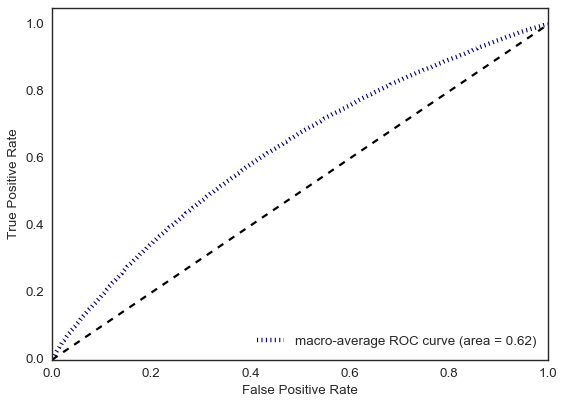

In [204]:
# roc curve for BoW
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc_curve(y_test, y_pred, title="", cmap="OrRd", curves='macro', text_fontsize='large')
plt.style.use('seaborn-colorblind')
plt.show()